In [99]:
from gibbs.dataclass import GibbsResult
import matplotlib.pyplot as plt
import numpy as np
from gibbs.learning.bayesian_learning import BayesianLearning
from gibbs.learning.constraint_matrix import ConstraintMatrixFactory
from qiskit.quantum_info import Statevector
from gibbs.learning.klocal_pauli_basis import KLocalPauliBasis
from scipy.linalg import block_diag
from scipy.sparse import bmat

from gibbs.utils import number_of_elements, simple_purify_hamiltonian
# plt.rcParams['text.usetex'] = True

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
n=4
k=2
nfields = 5
basisH = KLocalPauliBasis(k,n,False)
c_original = np.zeros(basisH.size); c_original[10:20]=1
control_fields = [np.zeros(basisH.size) for i in range(nfields+1)]
for i,cf in enumerate(control_fields[1:]):
    cf[i*5:(i+1)*5] = -0.25
cfaulty = c_original + np.random.rand(basisH.size)*0.1
states = [simple_purify_hamiltonian(basisH.vector_to_pauli_op(cfaulty + cfield)) for cfield in control_fields]

In [101]:
bl = BayesianLearning(
    states=states,
    control_fields= control_fields,
    constraint_matrix_factory= ConstraintMatrixFactory(n,k,k),
    prior_mean=c_original,
    prior_c_cov=np.eye(c_original.shape[0]),
    prior_cfield_cov=np.eye(c_original.shape[0])*1e-3,
    sampling_std= 1e-2,   
)

In [102]:
assert bl.constraint_matrices is None, "The constraint matrices have already been built"
bl.constraint_matrix(0);

In [103]:
# Lx = np.linalg.cholesky(block_diag(bl.current_inv_cov, bl.cfield_inv_cov))
# constraint_matrix = bmat(
#             [
#                 [   bl.constraint_matrix(0),
#                     None
#                 ],
#                 [
#                     bl.constraint_matrix(1),
#                     bl.constraint_matrix(1)
#                 ],
#             ]
#         )

0.15501924518471902
0.36601830980517747


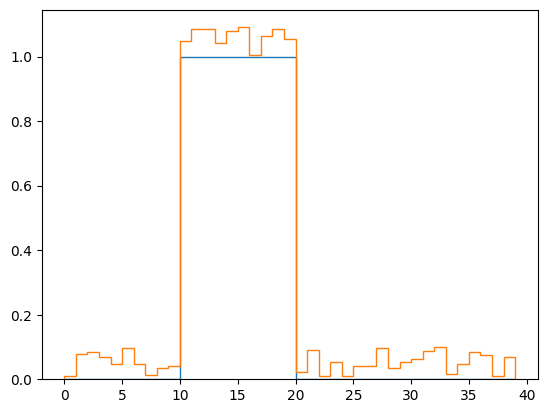

In [104]:
plt.stairs(c_original)
# plt.stairs(c_original+control_fields[1])
plt.stairs(cfaulty)
print(bl._cost_function(x=np.append(c_original,control_fields[1]),cfield_index = 1,A=constraint_matrix,Lx=Lx))
print(bl._cost_function(x=np.append(cfaulty,control_fields[1]),cfield_index = 1,A=constraint_matrix,Lx=Lx))

In [105]:
# from scipy.optimize import minimize
# def func(x):
#     cost =  bl._cost_function(x=x,cfield_index = 1,A=constraint_matrix,Lx=Lx)
#     print(cost)
#     return cost
# result = minimize(func,np.append(cfaulty,control_fields[1]),options={"maxiter":1e5,"xrtol":1e-5})

In [106]:
# plt.stairs(c_original,label = "prior")
# plt.stairs(result.x[:c_original.size],label = "guess")
# plt.stairs(cfaulty,label = "preparation")
# plt.legend()

In [107]:
for i in range(1,3):
    update = bl.update_mean(i)
    cov = bl.update_cov(update,i)
    bl.current_mean = update[:update.size//2]
    bl.current_cov = cov[:cov.shape[0]//2,:cov.shape[1]//2]

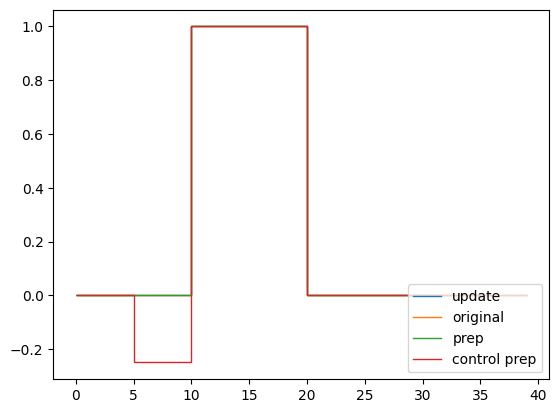

In [ ]:
plt.stairs(update[:update.size//2],label="update")
plt.stairs(c_original,label="original")
plt.stairs(cfaulty,label="prep")
plt.stairs(cfaulty+control_fields[2],label="control prep")
# plt.stairs(cov.diagonal()[:cov.diagonal().size])
plt.legend(loc="lower right")

In [ ]:
update[:update.size//2]-c_original

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])